In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import multivariate_normal
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# functions
def sample_from_task_sequence(t, N=10):
    if (t // (N/2)) % 2 == 0:
        mu = 1
    else:
        mu = -1
    Y = np.random.binomial(1, 0.5)
    X = np.random.normal((-1)**(Y+1)*mu, 0.5)
    return X, t, Y

def get_dataloader(X, Y):
    torch_X = torch.Tensor(X)
    torch_Y = torch.Tensor(Y)
    dataset = TensorDataset(torch_X, torch_Y)
    trainloader = DataLoader(dataset, batch_size=64, shuffle=True)
    return trainloader

def train(model, trainloader, num_epochs, lr=0.01, verbose=False):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        model.train()
        nb_batches = len(trainloader)
        losses = 0.0
        train_acc = 0.0
        for x, y in trainloader:
            x = x.to(device)
            y = y.long().to(device)

            out = model(x)
            loss = criterion(out, y)

            optimizer.zero_grad()
            loss.backward()
            losses += loss.item()
            optimizer.step()
            train_acc += (out.argmax(1) == y).cpu().numpy().mean()
        scheduler.step()
        if verbose and epoch % 100 == 0:
            print("Training loss at epoch {} : {:4f}, Training Acc : {:4f}".format(epoch+1, losses/nb_batches, train_acc/nb_batches))
    return model

def compute_cumulative_error(model, t, N, T, num_reps=10):
    preds = []
    gts = []
    model.eval()
    for rep in range(num_reps):
        testdata = np.array([sample_from_task_sequence(s, N) for s in range(t, T)])
        Xt = torch.Tensor(testdata[:, :-1])
        Yt = testdata[:, -1]
        out = model(Xt)
        preds.append(out.detach().argmax(1).numpy())
        gts.append(Yt)
    preds = np.array(preds)
    gts = np.array(gts)
    mean_error = np.mean(preds != gts)
    std_error = np.std(preds != gts)
    return mean_error, std_error

In [146]:
# archiectures 
class AttentionLayer(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim, p=0.1):
        super().__init__()
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, hidden_dim, p),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model, p),
            nn.ReLU()
        )
        self.mha = nn.MultiheadAttention(d_model, num_heads, p)
        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

    def forward(self, x):
        attn_output, _ = self.mha(x, x, x)
        out1 = self.layernorm1(x + attn_output)
        cnn_output = self.feed_forward(out1)
        out2 = self.layernorm2(out1 + cnn_output)
        return out2

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, d_model, num_heads, ff_hidden_dim, num_attn_blocks=1, num_classes=2):
        super().__init__()
        self.input_size = input_size
        self.d_model = d_model
        self.attention_blocks = nn.ModuleList(
            [AttentionLayer(d_model, num_heads, ff_hidden_dim) for _ in range(num_attn_blocks)]
        )
        self.dense = nn.Linear(d_model, num_classes)
        self.input_embedding = nn.Linear(input_size+1, d_model)

    # def position_encoder1(self, t):
    #     pe = torch.zeros(1, t.shape[1], self.d_model)
    #     theta = np.array([
    #         [t[j] * np.power(10000, i / self.d_model) for i in range(self.d_model)]
    #         for j in range(len(t))
    #     ]).squeeze().T
    #     print(len(t))
    #     pe[:, :, 0::2] = torch.FloatTensor(np.sin(theta[:, 0::2]))
    #     pe[:, :, 1::2] = torch.FloatTensor(np.cos(theta[:, 1::2]))
    #     self.register_buffer('pe', pe)
    #     return pe

    def position_encoder(self, t):
        pe = torch.zeros(1, t.shape[1], self.d_model)
        theta = np.array([
            [t[0, j, 0] / np.power(10000, 2 * (i // 2) / (self.d_model)) for i in range(self.d_model)]
            for j in range(t.shape[1])
        ]).squeeze()
        pe[:, :, 0::2] = torch.FloatTensor(np.sin(theta[:, 0::2]))
        pe[:, :, 1::2] = torch.FloatTensor(np.cos(theta[:, 1::2]))
        self.register_buffer('pe', pe)
        return pe

    def modulo_encoder(self, t):
        l = torch.arange(1, 20 + 1, 1)
        t_enc = torch.ones((len(l), t.shape[1])) * t.view(1, t.shape[1])
        t_enc = torch.fmod(t_enc, l.view(len(l), 1)) 
        return t_enc.view(1, t.shape[1], len(l))
        
    def forward(self, z):
        u = torch.index_select(z, -1, torch.tensor(list(range(0, self.input_size)) + [self.input_size + 1]))
        t = torch.index_select(z, -1, torch.tensor([self.input_size]))
        u = self.input_embedding(u)
        t = self.position_encoder(t)
        x = u + t
        for attn_block in self.attention_blocks:
            x = attn_block(x)
        x = torch.select(x, 1, x.shape[1]-1)
        x = self.dense(x)
        return x


In [147]:
N = 10
t = 1000

np.random.seed(1996)
data = np.array([sample_from_task_sequence(s, N) for s in range(0, t)])
data = torch.from_numpy(data)

In [150]:
batch_size = 32
num_epochs = 2000
hi = int(t * 0.9)
mid = int(t * 0.5)
lo = int(t * 0.1)
min_length = 200

lr = 0.01
verbose=True
model = TransformerClassifier(
    input_size=1,
    d_model=16, 
    num_heads=4,
    ff_hidden_dim=32,
    num_attn_blocks=2,
    num_classes=2
)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
criterion = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    model.train()
    losses = 0.0
    train_acc = 0.0
    for _ in range(batch_size):
        # tl = torch.randint(lo, mid, (1,)) # select the start of the subsequence
        # th = torch.randint(tl+min_length, hi, (1,)) # select the end of the subsequence
        # s = torch.randint(th+1, len(data), (1,)) # select a 'future' time beyond the subsequence
        # z = torch.cat((data[tl:th+1], data[s]))
        t = torch.randint(lo, hi, (1,)) # select the end of the subsequence
        s = torch.randint(t+1, len(data), (1,)) # select a 'future' time beyond the subsequence
        z = torch.cat((data[:t+1], data[s]))
        y = z[-1, -1].clone()
        z[-1, -1] = 0.5
        z = z.view(1, z.shape[0], z.shape[1])
        y = y.view(1)
        
        z = z.float().to(device)
        y = y.long().to(device)

        out = model(z)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        losses += loss.item()
        optimizer.step()
        train_acc += (out.argmax(1) == y).cpu().numpy().mean()
    scheduler.step()
    if verbose and epoch % 100 == 0:
        print("Training loss at epoch {} : {:4f}, Training Acc : {:4f}".format(epoch+1, losses/batch_size, train_acc/batch_size))

Training loss at epoch 1 : 0.709339, Training Acc : 0.468750
Training loss at epoch 101 : 0.728898, Training Acc : 0.375000
Training loss at epoch 201 : 0.716318, Training Acc : 0.437500
Training loss at epoch 301 : 0.701430, Training Acc : 0.531250
Training loss at epoch 401 : 0.609118, Training Acc : 0.750000
Training loss at epoch 501 : 0.696446, Training Acc : 0.437500
Training loss at epoch 601 : 0.662667, Training Acc : 0.625000
Training loss at epoch 701 : 0.680462, Training Acc : 0.500000
Training loss at epoch 801 : 0.486052, Training Acc : 0.750000
Training loss at epoch 901 : 0.351646, Training Acc : 0.875000
Training loss at epoch 1001 : 0.322118, Training Acc : 0.843750
Training loss at epoch 1101 : 0.154206, Training Acc : 0.937500
Training loss at epoch 1201 : 0.089752, Training Acc : 0.968750
Training loss at epoch 1301 : 0.342420, Training Acc : 0.937500
Training loss at epoch 1401 : 0.087144, Training Acc : 0.968750
Training loss at epoch 1501 : 0.179319, Training Acc

In [144]:
model = TransformerClassifier(
    input_size=1,
    d_model=16, 
    num_heads=4,
    ff_hidden_dim=32,
    num_attn_blocks=2,
    num_classes=2
)

In [145]:
t = torch.arange(1, 100, 1)
t = t.view(1, len(t), 1)
tic = time.time()
pe1 = model.position_encoder1(t).numpy().squeeze()
toc = time.time()
print("pe1 : ", toc - tic)

tic = time.time()
pe2 = model.position_encoder2(t).numpy().squeeze()
toc = time.time()
print("pe3 : ", toc - tic)

1
pe1 :  0.0011620521545410156
99
pe3 :  0.026921987533569336


In [134]:
import time
tic = time.time()

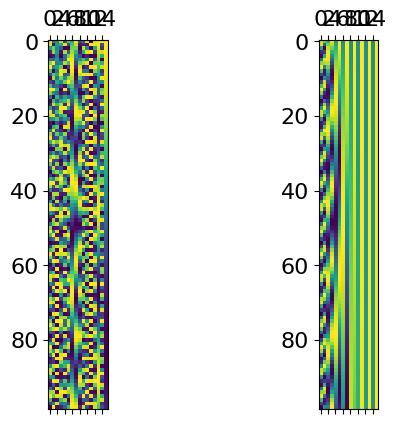

In [121]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(pe1)
ax[1].matshow(pe2)

In [117]:
t = 1000
T = 1200
num_reps = 10
preds = []
gts = []
model.eval()
for rep in range(num_reps):
    testdata = np.array([sample_from_task_sequence(s, N) for s in range(t, T)])
    testdata = torch.from_numpy(testdata)
    pred_rep = []
    gt_rep = []
    for s in range(len(testdata)):
        z = torch.cat((data[-200:], testdata[s].view(1, 3)))
        y = z[-1, -1].clone()
        z[-1, -1] = 0.5
        z = z.view(1, z.shape[0], z.shape[1])
        y = y.view(1)
        z = z.float().to(device)
        y = y.long().to(device)
        out = model(z)
        pred_rep.append(nn.functional.softmax(out, dim=1).detach().argmax(1).numpy())
        gt_rep.append(y)
    preds.append(pred_rep)
    gts.append(gt_rep)
preds = np.array(preds)
gts = np.array(gts)

In [118]:
mean_error = np.mean(preds != gts, axis=0).squeeze()
std_error = np.std(preds != gts, axis=0).squeeze()
ci = std_error * 1.96/np.sqrt(num_reps).squeeze()

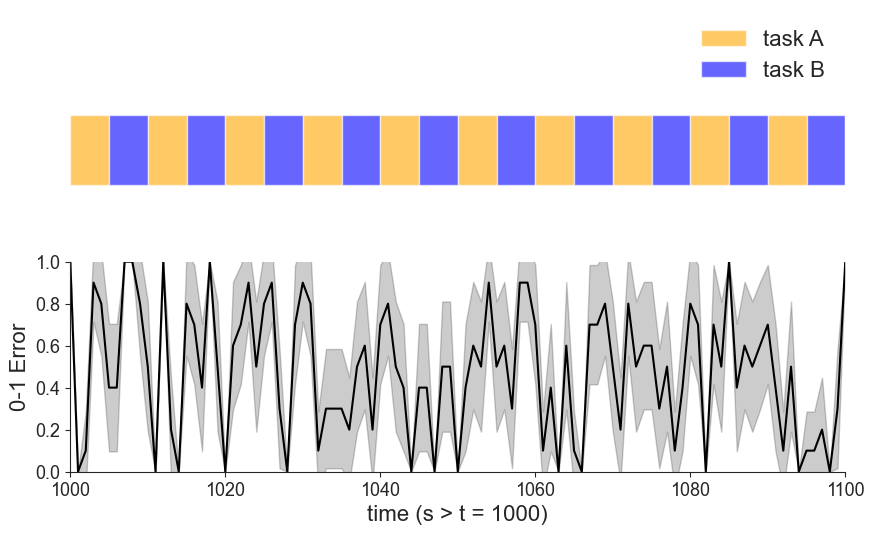

In [119]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
ax = axes[0]
end = 100+1
future = np.arange(t, t+end, 1)
errors = mean_error[:end]
c = ci[:end]
xlocs = np.arange(t, t+end, N/2)
for i, x in enumerate(xlocs):
    if i % 2 == 0:
        ax.add_artist(Rectangle((x, 0), N/2, 2, fc='orange', alpha=0.6))
    else:
        ax.add_artist(Rectangle((x, 0), N/2, 2, fc='b', alpha=0.6))
ax.set_ylim([-1, 5])
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
ax.axis('off')

sns.set_style("white")
sns.set_style("ticks")

ax = axes[1]
ax.plot(future, errors, c='k')
ax.fill_between(future, errors-c, errors+c, alpha=0.2, color='k')
ax.set_ylabel("0-1 Error", fontsize=16)
ax.set_xlabel("time (s > t = {})".format(t), fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.set_ylim([0, 1])
plt.show()



### time vs. cumulative risk over the future plot

In [11]:
N = 10
t_list = [100, 500, 1000, 1500, 2000]
T = 5000
num_epochs = 6000
num_reps = 100

data = np.array([sample_from_task_sequence(s, N) for s in range(0, t_list[-1])])

In [ ]:
cumulative_error = []
std_cumulative_error = []
for t in t_list:
    print(t)
    data_t = data[:t]
    X = data_t[:, :-1]
    Y = data_t[:, -1]
    trainloader = get_dataloader(X, Y)
    model = net2(d=1, h=50, num_periods=20, num_hidden=3, num_classes=2)
    model.to(device)
    model = train(model, trainloader, num_epochs, verbose=False)
    mean_err, std_err = compute_cumulative_error(model, t, N, T, num_reps)
    cumulative_error.append(mean_err)
    std_cumulative_error.append(std_err)
cumulative_error = np.array(cumulative_error)
std_cumulative_error = np.array(std_cumulative_error)
ci = std_cumulative_error * 1.96 / np.sqrt(num_reps)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(t_list, cumulative_error, 'o-')
ax.fill_between(t_list, cumulative_error-ci, cumulative_error+ci, alpha=0.2)
ax.set_xlabel('t')
ax.set_ylabel(r'cumulative risk until $T = {}$'.format(T))
plt.show()